# 高级模型架构
> 是时候介绍更高级的架构了！您将创建一个自动编码器来重建嘈杂的图像，可视化卷积神经网络激活，使用深度预训练模型进行图像分类，还将学习有关循环神经网络以及使用LSTM预测温度

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 8)

### 张量，层和自动编码器
- 张量
   - 深度学习中使用的主要数据结构。
   - 神经网络中的输入/输出和变换均使用张量来表示。
- 自动编码器
   - 使用场景
      - 降维
      - 去噪
      - 异常检测

### 这是一种张量的流动
如果您已经构建了一个模型，您可以使用 `model.layers` 和 `tf.keras.backend` 来构建函数，给定有效的输入张量，返回相应的输出张量。

当我们想要获得网络在中间层的输出时，这是一个有用的工具。

例如，如果您获得了网络的第一层的输入和输出，您可以构建一个 `inp_to_out` 函数，该函数返回通过仅对给定的输入张量进行前向传播后第一层的结果。

In [2]:
#导入我们之前学习真假钞票数据
banknote = pd.read_csv('../data/banknotes.csv')
banknote.head()

,variace,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
# 导入train_test_split函数
from sklearn.model_selection import train_test_split

 # 从banknote数据中删除 'class' 列，得到特征数据 
X = banknote.drop(['class'], axis=1) 

# 数据标准化
 # 对特征数据进行标准化处理，并转换为NumPy数组
X = ((X - X.mean()) / X.std()).to_numpy()  
# 获取目标变量数据
y = banknote['class']  

# 使用train_test_split函数分割数据集，将数据集分割为训练集和测试集，测试集占总数据集的30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  

In [4]:
# 从Keras库导入Sequential模型
from tensorflow.keras import Sequential  
# 从Keras库导入Sequential模型
from tensorflow.keras.layers import Dense 

 # 创建一个Sequential模型
model = Sequential() 

# 向模型中添加具有2个神经元、输入形状为(4, )、激活函数为ReLU的全连接层
# 添加第一层(Dense层)：2个神经元，输入形状为(4, )，激活函数为ReLU
model.add(Dense(2, input_shape=(4, ), activation='relu')) 

# 向模型中添加具有1个神经元、激活函数为Sigmoid的全连接层
model.add(Dense(1, activation='sigmoid'))  

 # 打印模型的摘要信息
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 导入模块
import tensorflow.keras.backend as K

# 从模型的第一层获取输入张量
inp = model.layers[0].input

# 从模型的第一层获取输出张量
out = model.layers[0].output


# 定义一个从输入到输出的函数
inp_to_out = K.function([inp],[out])
# 打印通过第一层传递 X_test 后的结果

print(inp_to_out([X_test]))

[array([[1.48696768e+00, 3.12902600e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [5.50205827e-01, 4.32352036e-01],
       [0.00000000e+00, 0.00000000e+00],
       [1.20932090e+00, 1.41102165e-01],
       [7.31401801e-01, 7.08402470e-02],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [1.41353846e+00, 9.56399441e-01],
       [4.44810927e-01, 5.06917357e-01],
       [2.05628657e+00, 1.04915905e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.83664072e-02],
       [1.41291690e+00, 7.41753638e-01],
       [1.30990565e+00, 1.67755932e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [2.10389209e+00, 1.08846939e+00],
       [6.26469135e-01, 3.17237759e-03],
       [1.46456

### 神经元分离
有点难！同学们集中注意力！！
我们讲通过绘图来监测一个神经网络模型在训练过程中的性能变化，并且通过可视化来展现模型对于测试数据集的分类决策边界的形成情况

神经元通过更新它们的权重来输出有助于它们更好地区分数据集中不同输出类别的数值来进行学习。我们将利用刚刚构建的 `inp_to_out()` 函数来可视化银行票据认证模型中第一层中两个神经元的输出，以便观察其学习过程。



In [6]:
def plot():
    # 创建一个图形和一行五列的子图
    fig, axes = plt.subplots(1, 5, figsize=(16, 8))
  
    # 对于每个子图和索引
    for i, a in enumerate(axes):
        # 绘制散点图，x坐标为layer_outputs[i]的第一列，y坐标为layer_outputs[i]的第二列，颜色由y_test决定，无边框
        a.scatter(layer_outputs[i][:, 0], layer_outputs[i][:, 1], c=y_test, edgecolors='none')
        # 设置子图标题，显示测试准确率
        a.set_title('Test Accuracy: {:3.1f} %'.format(float(test_accuracies[i]) * 100.))
    
    # 自动调整子图布局
    plt.tight_layout()

In [7]:
# 使用随机梯度下降（SGD）优化器、二元交叉熵损失和精度指标对模型进行编译
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
layer_outputs = []  # 用于存储第一层输出的列表
test_accuracies = []  # 用于存储测试准确率的列表

# 迭代21次，每次训练一个epoch
for i in range(0, 21):  
    
    # 训练模型1个epoch
    h = model.fit(X_train, y_train, batch_size=16, epochs=1, verbose=0)
    # 每经过4个epoch
    if i % 4 == 0:  
        
        # 获取第一层的输出
        layer_outputs.append(inp_to_out([X_test])[0])
        
        # 计算该epoch的模型准确率
        test_accuracies.append(model.evaluate(X_test, y_test)[1])

13/13 [==============================] - 0s 2ms/step - loss: 0.2796 - accuracy: 0.9757


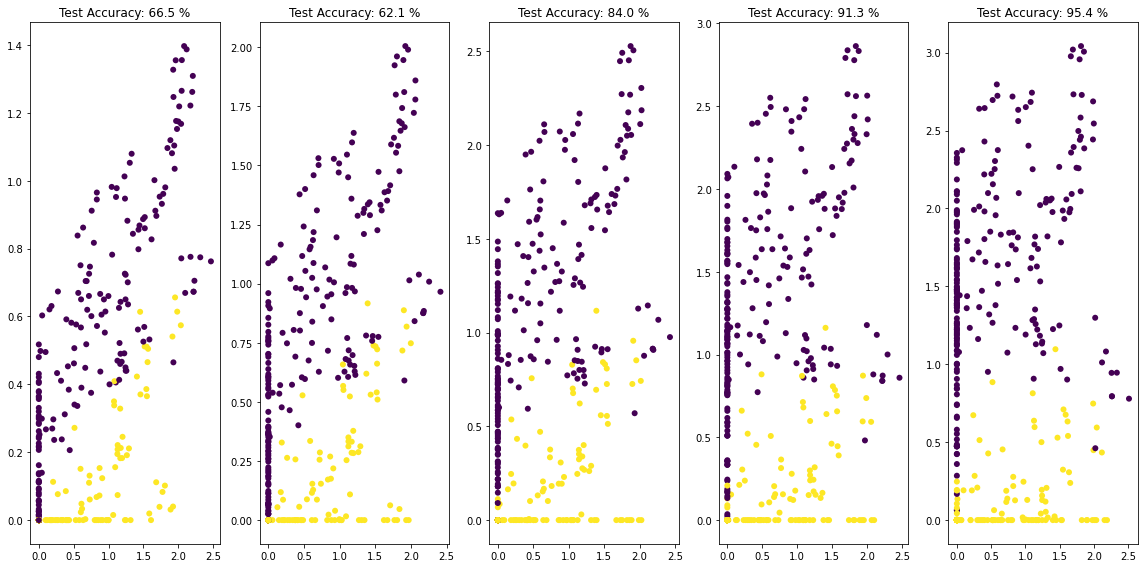

In [9]:
plot()


如果看一下这些图表，你可以看到神经元是如何学习根据它们是假的还是合法的美元钞票来分散输入的。（一张假美元钞票在图中表示为紫点）一开始，输出彼此更接近，随着时代的流逝，权重被学习，因此假钞和合法的美元钞票得到不同的、越来越远的输出。

模型随时间学习将数据映射到一个新的特征空间，在这个空间中，不同的数据点（或不同的类别）被其特征值清晰地分隔。这不仅有助于我们直观地理解模型的功能，还可以帮助我们诊断模型在学习过程中可能存在的问题。如果最后的散点图显示出数据点之间的清晰边界，那么表明模型在区分不同类别的数据方面表现的很好。如果边界模糊，数据点混杂，那么可能意味着模型的性能有待提高。

### 构建自动编码器
自动编码器具有诸多有趣的应用，比如异常检测或图像去噪。它的目标是产生与输入完全相同的输出。输入将被压缩成一个较低维度的空间，也就是被编码。模型然后学习如何将其解码回原始形式。

我们将对手写数字MNIST数据集进行编码和解码，隐藏层将对图像进行32维表示的编码，而原始图像由784个像素（28 x 28）组成。自动编码器实质上将学会将这784个像素的原始图像压缩为一个32个像素的压缩图像，并学会如何利用该编码表示将原始的784个像素图像恢复出来。

In [10]:
from tensorflow.keras.datasets import mnist  # 导入MNIST数据集模块

# 从MNIST数据集加载训练集和测试集
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 数据预处理：将像素值映射到0~1之间的浮点数，并进行重新格式化
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# 将训练集和测试集的二维图像数据转换为一维向量
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# 加载含有噪声的测试数据，并进行相应的数据预处理
X_test_noise = np.load('../data/X_test_MNIST_noise.npy')
X_test_noise = X_test_noise.reshape((len(X_test_noise), np.prod(X_test_noise.shape[1:])))
y_test_noise = np.load('../data/y_test_MNIST.npy')

In [11]:
# 创建一个名为'autoencoder'的Sequential模型
autoencoder = Sequential(name='autoencoder')
# 添加一个密集层，输入是原始图像像素，神经元数量为编码后的表示
autoencoder.add(Dense(32,input_shape=(784,),activation='relu'))
# 添加一个输出层，神经元数量与原始图像像素相同
autoencoder.add(Dense(784,activation='sigmoid'))

# 使用autoencoder编译模型
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 总结模型结构
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


### 像自动编码器一样去噪

刚刚建立了一个 `autoencoder` 模型。现在让我们看看它如何处理更具挑战性的任务。

首先，将构建一个编码图像的模型，并使用 `show_encodings()` 检查不同数字是如何表示的。为了构建编码器，同学们将利用已经训练过的自动编码器。我们将只使用网络的前半部分，其中包含输入和瓶颈输出。这样，将获得一个包含表示输入图像编码版本的 32 个数字的输出。

接下来，将把自动编码器应用到来自 MNIST 数据集的噪声图像上，它应该能够清除嘈杂的伪影。

这些噪音数据集中的数字看起来像这样：
![noise](../img/number.png)

In [12]:
def show_encodings(encoded_imgs, number=1):
    # 定义一个函数用于展示编码后的图像
    n = 5  # 我们会展示多少张图像
    original = X_test_noise  # 原始图像
    original = original[np.where(y_test_noise == number)]  # 选择特定类别的图像
    encoded_imgs = encoded_imgs[np.where(y_test_noise == number)]  # 选择特定类别的编码图像
    plt.figure(figsize=(20, 4))
    #plt.title('Original '+str(number)+' vs Encoded representation')

    # 展示原始图像和编码后的图像
    for i in range(min(n, len(original))):
        # 显示原始图像
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))  # 以灰度显示图像
        plt.gray()  # 灰度处理
        ax.get_xaxis().set_visible(False)  # 隐藏x轴
        ax.get_yaxis().set_visible(False)  # 隐藏y轴

        # 显示编码后的图像
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.tile(encoded_imgs[i], (32, 1)))  # 以灰度显示编码后的图像
        plt.gray()  # 灰度处理
        ax.get_xaxis().set_visible(False)  # 隐藏x轴
        ax.get_yaxis().set_visible(False)  # 隐藏y轴

def compare_plot(original, decoded_imgs):
    n = 4  # 展示多少张图像
    plt.figure(figsize=(20, 4))

    # 展示原始图像和重构后的图像
    for i in range(n):
        # 显示原始图像
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))  # 以灰度显示图像
        plt.gray()  # 灰度处理
        ax.get_xaxis().set_visible(False)  # 隐藏x轴
        ax.get_yaxis().set_visible(False)  # 隐藏y轴

        # 显示重构后的图像
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))  # 以灰度显示图像
        plt.gray()  # 灰度处理
        ax.get_xaxis().set_visible(False)  # 隐藏x轴
        ax.get_yaxis().set_visible(False)  # 隐藏y轴
    plt.title('Noisy vs Decoded images')  # 图像的标题

In [13]:
#训练自动编码器模型
autoencoder.fit(X_train,X_train, # 使用X_train作为输入和目标输出进行训练，重建原始数据
                epochs = 100,# 训练轮数
                batch_size=256,# 批量大小
                shuffle=True, # 在每个epoch开始前打乱数据
                validation_data = (X_test,X_test), # 使用X_test进行验证
                verbose=0# 不显示训练过程中的日志信息
                )

4/4 [==============================] - 0s 1ms/step


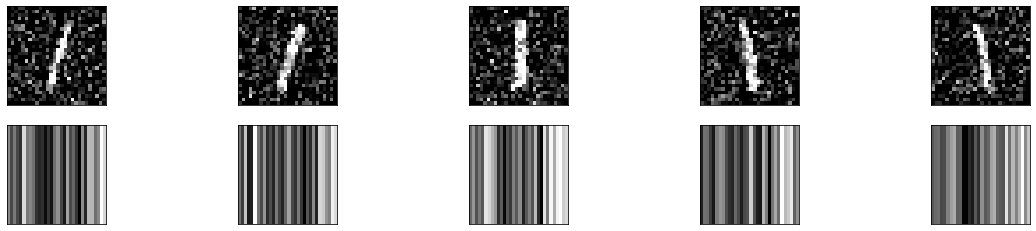

In [14]:
# 创建一个序贯模型来构建编码器
encoder = Sequential() 
# 将自动编码器（autoencoder）的第一层添加到编码器中
encoder.add(autoencoder.layers[0])

# 自动编码器的第一层通常是编码器部分，因此我们将其添加到我们的编码器模型中

# 编码嘈杂图像，并展示您最喜欢的数字[0-9]的编码结果
encodings = encoder.predict(X_test_noise)
# 使用编码器对噪声图像进行编码处理

# 展示编码结果，其中 number=1 代表显示数字1的编码结果
show_encodings(encodings,number=1)

4/4 [==============================] - 0s 1ms/step


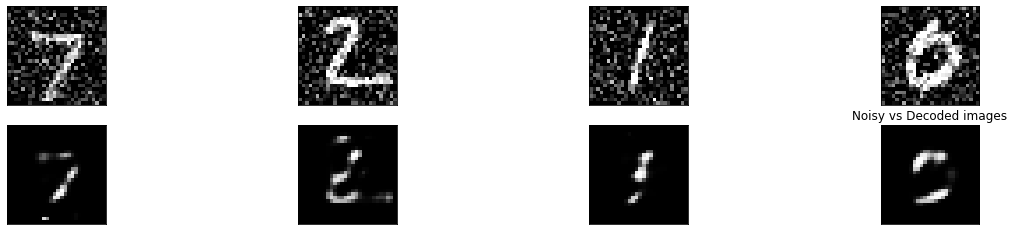

In [15]:

# 使用训练好的自动编码器对噪声测试图片进行重建
decoded_imgs = autoencoder.predict(X_test_noise)
# 绘制噪声图像与重建图像的对比
# 调用compare_plot函数，将噪声图像与重建图像进行对比并进行绘制
compare_plot(X_test_noise,decoded_imgs)

## 在TensorFlow中实现CNN
![cnn](../img/CNN.png)

在Keras中构建CNN模型并不比已经构建的任何模型更困难！你只需要利用卷积层。

我们将构建一个浅层卷积 model 来对MNIST数字数据集进行分类。这就是你用自动编码器去噪的那个数据集！这些图像是 28 x 28 像素，并且只有一个通道，因为它们是黑白图片。


In [16]:
# 从tensorflow.keras.layers中导入Conv2D和Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

# 实例化模型
model = Sequential()


# 添加一个包含32个3x3大小的过滤器的卷积层，输入尺寸为(28, 28, 1)，激活函数为ReLU
model.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), activation='relu'))

# 添加一个包含16个3x3大小的过滤器的卷积层，激活函数为ReLU
model.add(Conv2D(16, kernel_size=3, activation='relu'))


# 将前一层的输出展平
model.add(Flatten())

# 添加和类别数相同的输出，并使用softmax激活函数
model.add(Dense(10, activation='softmax'))

### 观察卷积
通过Keras模型对象，构建一个新的模型，使它能够输出第一个卷积层对于MNIST数据集中数字图像的激活。

这意味着您将能够观察并理解第一个卷积层学到的卷积核。卷积核是卷积神经网络用来提取输入数据特征的部分，观察它们有助于理解网络如何理解输入并作出相应的预测。这是学习卷积神经网络结构和工作原理中非常酷的一部分！

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                92170     
                                                                 
Total params: 97,114
Trainable params: 97,114
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 载入 MNIST 数据集，其中包含手写数字的图像及其对应的标签
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 重新塑形训练和测试数据，以使其与卷积神经网络（CNN）的输入兼容
#原理上来说-1是一个占位符，它告诉NumPy："我在这个位置上需要一个维度，但具体是多大，你得查看数据并帮我计算出来。"
#这样你就不需要手动计算样本数量，使代码更灵活，尤其是样本数量可能发生变化时。
X_train = np.reshape(X_train,[-1,28,28,1])
X_test = np.reshape(X_test,[-1,28,28,1])

In [19]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [20]:
# 配置模型以进行训练
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# 训练模型
model.fit(X_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
1875/1875 [==============================] - 8s 2ms/step - loss: 0.2717 - accuracy: 0.9429
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0794 - accuracy: 0.9762
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0534 - accuracy: 0.9834
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0414 - accuracy: 0.9872
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0320 - accuracy: 0.9901
Epoch 6/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0274 - accuracy: 0.9915
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0239 - accuracy: 0.9929
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0224 - accuracy: 0.9932
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0192 - accuracy: 0.9946
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.015

In [21]:
# 获取第一层的输出
first_layer_output = model.layers[0].output
# 使用模型的输入和第一层的输出来构建一个新模
first_layer_model = tf.keras.models.Model(inputs=model.layers[0].input,outputs= first_layer_output)
# 使用这个模型对 X_test 进行预测

activations = first_layer_model.predict(X_test)

313/313 [==============================] - 0s 759us/step


In [22]:
#看到模型第一层有多少个滤波器
# 获取第一个卷积层
first_conv_layer = model.layers[0]
# 检查是否是一个卷积层
if isinstance(first_conv_layer,Conv2D):
    num_filters = first_conv_layer.filters
    print(num_filters)


32


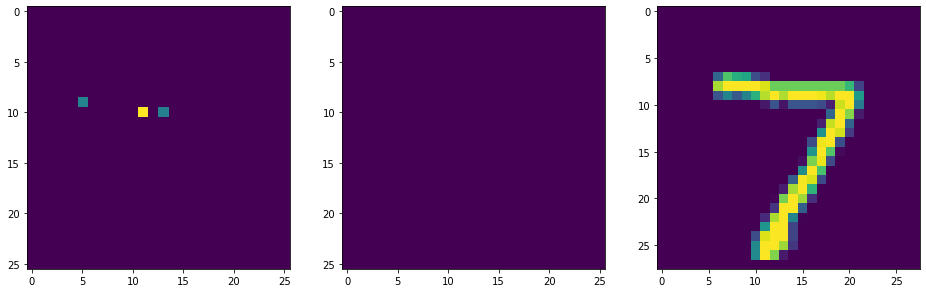

In [23]:
import matplotlib.pyplot as plt

# 创建一个图形窗口，包含 1 行 3 列的子图，设置图形的尺寸为 16x8
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# 绘制X_test中第一个数字对应第6个滤波器的激活。
axs[0].imshow(activations[0, :, :, 6], cmap='viridis')

# 绘制X_test中第一个数字对应第2个滤波器的激活。
axs[1].imshow(activations[0, :, :, 2], cmap='viridis')

# 在第三个子图中绘制X_test中第一个数字的原始图像
axs[2].imshow(X_test[0, :, :, 0], cmap='viridis')



在卷积神经网络（CNN）中，每个卷积层由多个滤波器（也称为卷积核）组成，每个滤波器都学习来自输入数据的特定特征。虽然CNN通常在训练过程中学习到有意义的特征，但是某些滤波器可能会"学不到"或学到一些对最终任务没有帮助的特征，这种情况是可能出现的。

第一层的每个神经元滤波器都学习了不同的卷积。第 5 个滤波器学会了检测数字中的垂直迹线。另一方面，过滤器 1 似乎正在检查水平轨迹。

### 准备输入图像
原始的ResNet50模型是使用尺寸为224 x 224像素的图像进行训练的（ResNet50 是在大规模图像数据集（如 ImageNet）上进行训练的，而 ImageNet 数据集中的图片大小通常是 224x224 或 256x256。因此，使用原始的 ResNet50 模型时，推荐使用 224x224 的图片尺寸以获得最佳效果。），并进行了多项预处理操作；例如减去训练集中所有训练图像的平均像素值。您需要以相同的方式预处理要进行预测的图像。

当对单个图像进行预测时，需要调整其形状以符合模型的输入要求。在这种情况下，模型的输入形状通常为(batch-size, 宽度, 高度, 通道数)。你可以使用 np.expand_dims，并设置参数 axis = 0 来添加 batch-size 维度。由于我们只对一张图像进行预测，因此这里的 batch-size 维度取值为1。

在准备这张名为Ivy的狗的图像时，您将按照这些预处理步骤进行操作，使其能够被ResNet50分类。


![dog](../data/dog.png)

 ResNet50 能够识别 1000 个不同的类别，比如：不同种类的狗、猫、车辆、植物、多种日用品和场景等。每一个类别都对应于一个特定的标签，模型输出的就是这些类别标签的概率分布。

In [24]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# 使用合适的目标尺寸加载图像以供模型使用
img = image.load_img('../data/dog.png',target_size=(224,224))
# 将图像转换为数组
img_array = image.img_to_array(img)
# 扩展图像的维度，使其符合预期的模型输入格式
img_expanded = np.expand_dims(img_array,axis=0)
# 以原始图像相同的方式对图像进行预处理
img_ready = preprocess_input(img_expanded)


Ivy的照片已经准备好可以被ResNet50使用了。ResNet50是一个在Imagenet数据集上训练过的模型，能够区分1000种不同的标记对象。  
ResNet50是一个深层模型，共有50层，你可以在[这里](https://tensorspace.org/html/playground/resnet50.html) 以3D形式查看它:。

In [25]:
# 从keras应用中导入ResNet50模型和结果解码函数
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions

# 用'imagenet'权重实例化一个ResNet50模型
model = ResNet50(weights = 'imagenet')
# 使用ResNet50对已经处理过的图像进行预测
preds = model.predict(img_ready)
# 解码前3个预测结果
print('预测结果:',decode_predictions(preds,top=3)[0])

1/1 [==============================] - 1s 810ms/step
预测结果: [('n02088364', 'beagle', 0.9073352), ('n02089867', 'Walker_hound', 0.0662683), ('n02089973', 'English_foxhound', 0.018874545)]


### 对于自定义数据集进行训练

### CIFAR-10数据集简介：
 - CIFAR-10数据集由60,000张32x32像素的彩色图像组成，这些图像分属于10个不同的类别，每个类别6000张图像。
 - 这10个类别分别是：飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。
 - 0: airplane，1: automobile，2: bird，3: cat，4: deer，5: dog，6: frog，7: horse，8: ship，9: truck

 
 ![dog](../img/CIFAR-10%E6%95%B0%E6%8D%AE%E9%9B%86.png)

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [27]:
import numpy as np
import os
import pickle

# CIFAR-10 数据集加载函数
def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(os.path.join(cifar10_dataset_folder_path, 'data_batch_' + str(batch_id)), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

def load_cifar10_data(cifar10_dataset_folder_path):
    # 训练数据集
    x_trn = None
    y_trn = []
    for i in range(1, 6):
        features, labels = load_cifar10_batch(cifar10_dataset_folder_path, i)
        if x_trn is None:
            x_trn = features
        else:
            x_trn = np.vstack((x_trn, features))
        y_trn += labels
        
    # 测试数据集
    with open(os.path.join(cifar10_dataset_folder_path, 'test_batch'), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    x_tst = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    y_tst = batch['labels']
    
    y_trn = np.array(y_trn)
    y_tst = np.array(y_tst)
    
    return (x_trn, y_trn), (x_tst, y_tst)

# 指定CIFAR-10数据集的路径
cifar10_path = '../data/cifar-10-batches-py/'

# 使用自定义函数加载数据集
(train_images, train_labels), (test_images, test_labels) = load_cifar10_data(cifar10_path)

In [28]:
# 对图片进行预处理
train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)

# 将标签转换为 one-hot 编码
train_labels = to_categorical(train_labels,10)
test_labels = to_categorical(test_labels, 10)


# 加载 ResNet50 模型，不包括顶层 (即全连接层)
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(32,32,3))

# 冻结预训练模型的所有层
for layer in  base_model.layers:
    layer.trainable = False

# 构建我们自己的模型顶层
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(test_images, test_labels))

# 在测试集上评价模型性能
scores = model.evaluate(test_images, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# 对测试集中的一个图像进行预测
predictions = model.predict(test_images[:1])
predicted_class = np.argmax(predictions[0], axis=-1)
print('Predicted class:', predicted_class) 

Epoch 1/10
1563/1563 [==============================] - 23s 13ms/step - loss: 1.2880 - accuracy: 0.5926 - val_loss: 1.0888 - val_accuracy: 0.6380
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8133 - accuracy: 0.7186 - val_loss: 1.0484 - val_accuracy: 0.6522
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.6139 - accuracy: 0.7878 - val_loss: 1.0286 - val_accuracy: 0.6644
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.4608 - accuracy: 0.8478 - val_loss: 1.0273 - val_accuracy: 0.6734
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.3410 - accuracy: 0.8909 - val_loss: 1.0679 - val_accuracy: 0.6686
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.2486 - accuracy: 0.9291 - val_loss: 1.1344 - val_accuracy: 0.6613
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.1789 - accuracy: 0.9539 - val_loss: 1.1597 -

## 如何在TensorFlow中实现LSTM
- RNN（卷积神经网络）
- LSTM(长短期记忆)


**LSTM可以解决哪些问题？**
- **时间序列预测**：应用于交通流量、人口数量等时间序列数据的预测问题。
- **时间序列分类**：犯罪率预测与安全规划、城市基础设施规划、能源需求预测与管理、
- **动作识别与行为分析**：用于动作识别、行为分析以及视频内容理解，例如交通场景中的行人行为分析等。
- 生成模型
- 推荐系统
- 语音识别
- 自然语言处理任务


### 基于时间序列数据使用LSTM预测天气
利用长短期记忆网络（LSTM），一个颇具潜力的深度学习方法，可以对时间序列数据执行精确的天气预测。LSTM的特别之处在于其能够捕捉和利用长期依赖关系，这在气象数据分析中尤为关键，因为天气模式往往显示出复杂的季节性和非线性特征。经过适当训练，LSTM模型可以从过去的气温、湿度、气压等数据中学习，并对未来的条件作出预测，从而帮助气象学家和公众更好地准备未来的天气变化。此类模型的使用不仅只是为了预测明天会不会下雨，还能对气候趋势、极端天气事件的预测等更广泛的应用提供支持。

我们导入数据`test.csv`文件，并对数据进行清理

In [29]:
#导入一些要用到的包
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [30]:
df = pd.read_csv('../data/testset.csv')
# 清除DataFrame列名中的前导空格（如果存在）使用lstrip方法移除列名的前导空格
df.columns = df.columns.str.lstrip() 

# 清除DataFrame列名中的尾随空格（如果存在）
df.columns = df.columns.str.rstrip() 

# 打印出DataFrame的长度，即里面有多少条数据（行数）
print(len(df))

# 打印出DataFrame的开始五行作为样本数据，用于快速查看表格的结构和数据类型
df.head() 

100990


,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


使用了Matplotlib和Seaborn库来创建一个直方图，用于分析DataFrame df 中 '_tempm' 列的温度分布情况。

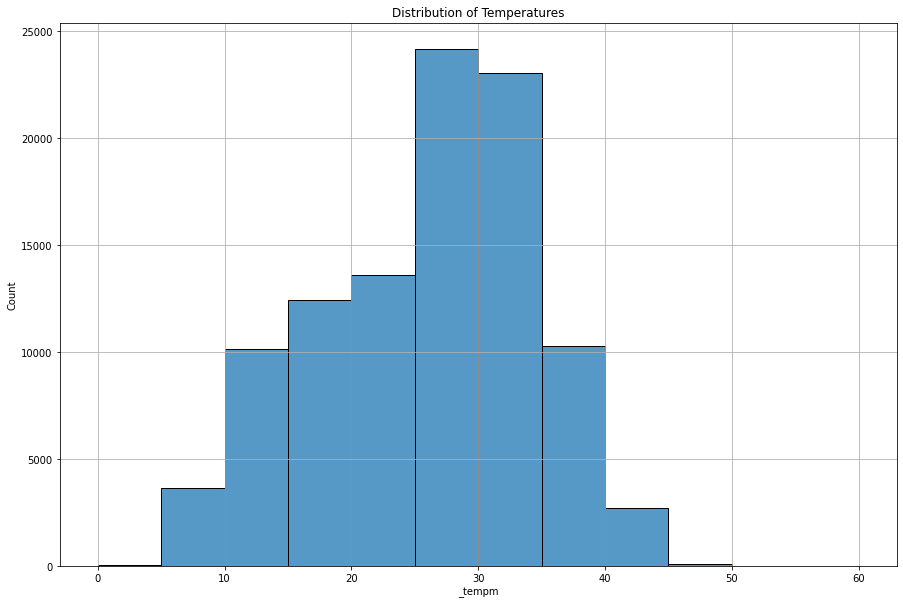

In [31]:
# 调用Matplotlib的figure函数来创建一个新的图形实例
plt.figure(figsize=(15, 10))  # 设置图形的大小为宽15英寸、高10英寸

# 使用Seaborn库中的histplot函数绘制直方图
# df['_tempm']为DataFrame中用于绘图的列名，代表温度数据
# bins参数定义了直方图的区间，这里使用列表推导式创建了一个列表，包含从0到60的整数，步长为5
# kde设置为False意味着不绘制核密度估计（Kernel Density Estimate），即不在直方图下方显示估计的概率密度曲线
sns.histplot(df['_tempm'], bins=[i for i in range(0, 61, 5)], kde=False)

# 使用title函数设置图形的标题为"Distribution of Temperatures"
plt.title("Distribution of Temperatures")

# 调用grid函数，在图形中添加网格线，这有助于更好地查看和定位直方块
plt.grid()

plt.show()

用来设置Pandas DataFrame的索引，并且过滤出特定的列。

In [32]:
# 设置数据索引为'datetime_utc'列
# pd.to_datetime将'datetime_utc'列的每个值转换为Pandas的datetime对象，这允许使用datetime相关功能
# 比如日期筛选、时间序列分析等
df.index = pd.to_datetime(df['datetime_utc'])

# 定义一个列表，其中包含我们选择保留在DataFrame中的列名
required_cols = ['_dewptm', '_fog', '_hail', '_hum', '_rain', '_snow', '_tempm', '_thunder', '_tornado']

# 根据required_cols列表中的列名过滤DataFrame，只保留这些列
# 这一步用于删除DataFrame中非必要的列，可能是因为我们只需要这些列来进行后续分析或建模
df = df[required_cols]

# 打印调整后DataFrame的前五行，查看索引和过滤后的列
# head方法默认返回前五行，它提供了一种快速验证数据索引和内容的方法
df.head()

,_dewptm,_fog,_hail,_hum,_rain,_snow,_tempm,_thunder,_tornado
datetime_utc,,,,,,,,,
1996-11-01 11:00:00,9.0,0,0,27.0,0,0,30.0,0,0
1996-11-01 12:00:00,10.0,0,0,32.0,0,0,28.0,0,0
1996-11-01 13:00:00,11.0,0,0,44.0,0,0,24.0,0,0
1996-11-01 14:00:00,10.0,0,0,41.0,0,0,24.0,0,0
1996-11-01 16:00:00,11.0,0,0,47.0,0,0,23.0,0,0


删除空值

In [33]:
df.isna().sum()
# 使用fillna函数填充DataFrame中的NaN值
# method='ffill'参数意味着使用前一行的值来填充当前行的NaN值，“ffill”是forward fill的缩写
df = df.fillna(method='ffill')
df.tail()

,_dewptm,_fog,_hail,_hum,_rain,_snow,_tempm,_thunder,_tornado
datetime_utc,,,,,,,,,
2017-04-24 06:00:00,17.0,0,0,25.0,0,0,34.0,0,0
2017-04-24 09:00:00,14.0,0,0,16.0,0,0,38.0,0,0
2017-04-24 12:00:00,12.0,0,0,14.0,0,0,36.0,0,0
2017-04-24 15:00:00,15.0,0,0,27.0,0,0,32.0,0,0
2017-04-24 18:00:00,15.0,0,0,30.0,0,0,30.0,0,0


采集每天的平均温度

In [34]:
# 使用resample方法对DataFrame进行时间序列的重新采样
# 'D'参数指定了重新采样的频率为每天（Day）
# 由于DataFrame的索引已经设置为datetime对象，resample根据这个时间索引按照天进行重新分组
# 之后，对每个分组（即每天）使用mean方法计算所有列的平均值
# 这对于生成每天所有气象变量的平均读数特别有用，适用于日级别的时间序列分析
df_final = df.resample('D').mean()

# 现在DataFrame（df_final）包含的是按天计算的平均值，而不是原始的逐小时或逐分钟数据
# 使用head方法输出变换后的DataFrame的前五行数据
# 这可以给我们展示经过重新采样和平均计算后的数据的前五天内容
df_final.head()

,_dewptm,_fog,_hail,_hum,_rain,_snow,_tempm,_thunder,_tornado
datetime_utc,,,,,,,,,
1996-11-01,11.666667,0.0,0.0,52.916667,0.0,0.0,22.333333,0.0,0.0
1996-11-02,10.458333,0.0,0.0,48.625000,0.0,0.0,22.916667,0.0,0.0
1996-11-03,12.041667,0.0,0.0,55.958333,0.0,0.0,21.791667,0.0,0.0
1996-11-04,10.222222,0.0,0.0,48.055556,0.0,0.0,22.722222,0.0,0.0
1996-11-05,8.200000,0.0,0.0,29.400000,0.0,0.0,27.800000,0.0,0.0


In [35]:
df_final.isna().sum()
df_final = df_final.fillna(method='ffill')


In [36]:
#检查一下列表是否含有空值
df_final.isna().sum()

_dewptm     0
_fog        0
_hail       0
_hum        0
_rain       0
_snow       0
_tempm      0
_thunder    0
_tornado    0
dtype: int64

进行了数据规范化、创建了时间序列序列及其标签，并最后将数据分割为训练集和测试集。

In [37]:
# 导入 sklearn.preprocessing 中的 MinMaxScaler 类，这个类可以将每个特征缩放到给定的范围，通常是0到1
from sklearn.preprocessing import MinMaxScaler

# 初始化MinMaxScaler对象
scaler = MinMaxScaler()

# 将scaler拟合到df_final上，并转换df_final，使其所有特征值缩放到0和1之间
scaled_data = scaler.fit_transform(df_final)

# 定义序列长度，即模型观察的时间步长
sequence_length = 10

# 确定特征数量，即输入中的变量数
num_features = len(df_final.columns)

# 创建序列和相应的标签列表
sequences = []
labels = []

# 生成训练数据序列及其对应标签
# 序列由连续的10天数据组成，标签是紧随序列后的第11天中的温度数据
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][6]
    sequences.append(seq)
    labels.append(label)
    
    
    
# 将序列和标签列表转换为numpy数组，以便输入到LSTM模型中
sequences = np.array(sequences)
labels = np.array(labels)

# 按80-20的比例分割数据为训练集和测试集
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

# 打印训练和测试数据集的形状
print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (5976, 10, 9)
Train Y shape: (5976,)
Test X shape: (1494, 10, 9)
Test Y shape: (1494,)


In [38]:
# 导入Keras库中的必要组件
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 创建一个Sequential模型实例。Sequential模型是多个网络层的线性堆叠。
model = Sequential()

# 向模型中添加LSTM层。LSTM是长短期记忆层，对时间序列数据特别有效。
# 设置LSTM层有128个单元（神经元），并根据训练数据的形状确定输入的形状。
# 由于后面还有LSTM层，所以这里设置return_sequences=True，以返回每个时间步的输出。
model.add(LSTM(units=128,input_shape=(train_x.shape[1], train_x.shape[2]),return_sequences=True))

# 添加Dropout层，以减少过拟合。Dropout层会在训练过程中随机将输入单元的一部分设置为0，
# 这里的丢弃比率是0.2（即20%的输入单元会被随机丢弃）。
model.add(Dropout(0.2))

# 再添加一个LSTM层，这次用64个单元。
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))


# 添加最后一个LSTM层，单元数减少到32，并且return_sequences设置为False，
# 因此这个层只会返回最终的输出，为密集层做准备。
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# 添加一个Dense层。这里只有一个单元，用于输出最终预测结果。
model.add(Dense(units=1))



# 编译模型，使用adam优化器进行训练，这是一种广泛使用的优化算法。
# 设置损失函数为均方误差，这是回归问题中常用的损失函数。
model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           70656     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [40]:
# 定义早停（Early Stopping）回调函数。
# ‘monitor’参数设置为监控验证集（validation set）的损失（'val_loss'），
# ‘patience’参数设置为5，意味着在验证集损失连续5个epoch没有改善时停止训练。
# ‘restore_best_weights’设置为True，即训练停止时恢复到最佳模型权重。
early_stopping = EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
# 定义模型检查点（Model Checkpoint）回调函数。
# 这将在每个epoch后保存当前权重，但仅当该epoch的验证集损失是到目前为止最好的时。
# ‘monitor’参数设置为‘val_loss’代表监控的是验证集上的损失，
# ‘save_best_only’设置为True代表仅保存最佳模型的权重。
model_checkpoint = ModelCheckpoint('best_model_weights.h5',monitor='val_loss',save_best_only=True)
# 训练（拟合）模型
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks = [early_stopping,model_checkpoint]
)

Epoch 1/100
75/75 [==============================] - 5s 20ms/step - loss: 0.0328 - val_loss: 0.0047
Epoch 2/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0097 - val_loss: 0.0043
Epoch 3/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 4/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0088 - val_loss: 0.0054
Epoch 5/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0080 - val_loss: 0.0040
Epoch 6/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 7/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0075 - val_loss: 0.0051
Epoch 8/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 9/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 10/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0069 - val_loss: 0.0036

In [41]:
# 使用TensorFlow的加载模型功能，加载之前保存的最佳模型权重。
# 这里假设在上一个代码块中定义的ModelCheckpoint回调已经在训练过程中保存了最佳模型的权重到文件 'best_model_weights.h5'。
best_model = tf.keras.models.load_model('best_model_weights.h5')


# 使用加载的最佳模型对测试集（test_x, test_y）进行评估。
# 这将返回在测试集上计算的损失值。
test_loss = best_model.evaluate(test_x, test_y)

# 打印测试集上的损失。
# 这里的“Test Loss”是指模型在测试集上的表现，它是通过比较模型的预测输出和实际标签计算出的损失函数的值。
print("Test Loss:", test_loss)

47/47 [==============================] - 1s 4ms/step - loss: 0.0020
Test Loss: 0.00201834412291646


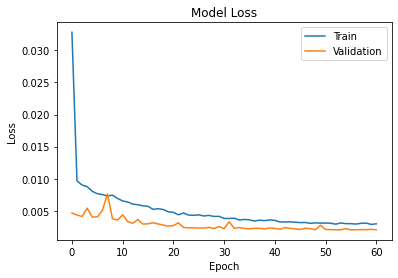

In [42]:
# 此行代码绘制训练集上的损失值，对应每个epoch。
# history.history['loss']包含了从第一个epoch到最后一个epoch模型在训练集上的损失值。
plt.plot(history.history['loss'])

# 此行代码在同一幅图上绘制验证集上的损失值。
# history.history['val_loss']包含了从第一个epoch到最后一个epoch模型在验证集上的损失值。
plt.plot(history.history['val_loss'])

# 此行代码设置图表的标题。
plt.title('Model Loss')

# 此行代码设置x轴的标签，表示每次迭代所代表的是不同的epoch。
plt.xlabel('Epoch')

# 此行代码设置y轴的标签，表示损失的量度。
plt.ylabel('Loss')

# 此行代码添加图例，指定了两个数据序列的标签为'Train'和'Validation'。
# 图例的位置设定为'upper right'，即图的右上角。
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [43]:
# 首先，需要从sklearn.metrics导入必要的性能度量函数，
# 包括平均绝对误差（MAE）和平均平方误差（MSE）。
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 使用训练好的模型来进行预测，得到测试集的预测结果。
predictions = best_model.predict(test_x)

# 计算真实值和预测值之间的平均绝对误差（MAE）。
# 这是一个衡量预测值与真实值之间差异的度量，它是所有单个观测值的绝对误差的平均。
mae = mean_absolute_error(test_y, predictions)

# 计算真实值和预测值之间的平均平方误差（MSE）。
# 与 MAE 相比，MSE 会对较大的误差赋予更高的权重（因为差异是平方计算的）。
mse = mean_squared_error(test_y, predictions)

# 计算均方根误差（RMSE），它是 MSE 的平方根。
# RMSE 相比于 MSE 有一个优点，那就是它和原来的目标值在同一个量级上，因此更易理解。
rmse = np.sqrt(mse)

# 打印出 MAE, MSE 和 RMSE 的值。
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

47/47 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 0.035025321979410606
Mean Squared Error (MSE): 0.0020183437899402804
Root Mean Squared Error (RMSE): 0.04492598123514144


In [44]:
# 真实值
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,6]

# 预测值
prediction = best_model.predict(test_x)
prediction_copies = np.repeat(prediction, 9, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,6]

47/47 [==============================] - 0s 3ms/step


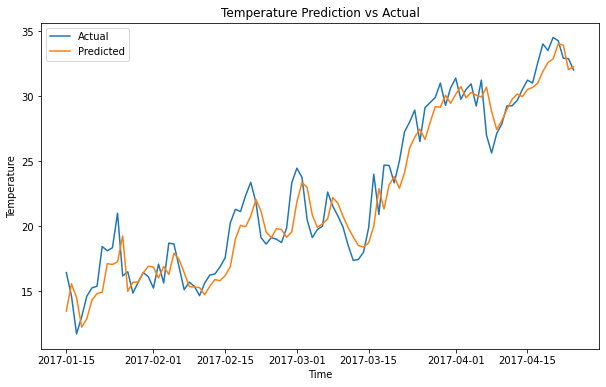

In [45]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(10, 6))


# 这里取的是数据集中最后100个数据点的索引；'true_temp[-100:]'指的是对应的真实温度值。
# 'label'参数为这条线设置一个标签，该标签将在图例中显示。
plt.plot(df_final.index[-100:], true_temp[-100:], label='Actual')
# 这行代码绘制了预测温度的图线。和真实温度的绘制方法相同，
# 只是数据源改为了预测温度值'predicted_temp[-100:]'。
plt.plot(df_final.index[-100:], predicted_temp[-100:], label='Predicted')
plt.title('Temperature Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()